# Notebook meant to show how to manipulate and get info from paircount .npy files

In [2]:
import numpy as np
import os
import sys
from matplotlib import pyplot as plt

In [8]:
survey = 'main'
#dirxi = os.environ['CSCRATCH']+'/'+survey+'xi/' #you probably didn't save output in the same place, so commenting this
dirxi = '/global/cscratch1/sd/ajross/mainxi/' #permissions should allow desi to open the files here

In [6]:
pc = np.load(dirxi+'paircounts_LRGmain_0.41.1test_defaultlin.npy',allow_pickle=True) #paircounts file for main LRGs 0.4 < z < 1.1

In [9]:
pc.dtype #pc is just an object containing dictionaries, 
#accessing the info is different than the structure arrays or tables you might be more used to

dtype('O')

In [11]:
# pc.item() will print the items, each item beging a dictionary, including arrays, etc., so there will be a lot

In [12]:
#This will print the names of the dictionaries and the keys they contain
for key in list(pc.item().keys()):
    
    if isinstance(pc.item()[key], dict):
        print('\n')
        print('the contents of '+key+' are:')
        for nk in list(pc.item()[key].keys()):
            print(nk,type(pc.item()[key][nk]))
    if isinstance(pc.item()[key], str):
        print(key,pc.item()[key])
    if isinstance(pc.item()[key],(str,dict)) == False:
        print(key,type(pc.item()[key]))

name landyszalay


the contents of D1D2 are:
name <class 'str'>
autocorr <class 'bool'>
seps <class 'list'>
wcounts <class 'numpy.ndarray'>
wnorm <class 'numpy.float64'>
edges <class 'tuple'>
mode <class 'str'>
bin_type <class 'str'>
boxsize <class 'NoneType'>
los <class 'str'>
compute_sepavg <class 'bool'>
weight_attrs <class 'dict'>
attrs <class 'dict'>


the contents of D1R2 are:
name <class 'str'>
autocorr <class 'bool'>
seps <class 'list'>
wcounts <class 'numpy.ndarray'>
wnorm <class 'numpy.float64'>
edges <class 'tuple'>
mode <class 'str'>
bin_type <class 'str'>
boxsize <class 'NoneType'>
los <class 'str'>
compute_sepavg <class 'bool'>
weight_attrs <class 'dict'>
attrs <class 'dict'>


the contents of R1R2 are:
name <class 'str'>
autocorr <class 'bool'>
seps <class 'list'>
wcounts <class 'numpy.ndarray'>
wnorm <class 'numpy.float64'>
edges <class 'tuple'>
mode <class 'str'>
bin_type <class 'str'>
boxsize <class 'NoneType'>
los <class 'str'>
compute_sepavg <class 'bool'>
weight_at

In [13]:
#So that tells us paircounts were run assuming a Landy-Szalay estimator and we have a separate dictionary for 
#D1D2, D1R2, and R1R2

In [15]:
#have it print out the info for each that is just a string
keys = ['D1D2','D1R2','R1R2']
for key in keys:
    print(key+':')
    tm = pc.item()[key]
    for nk in list(tm.keys()):
        if isinstance(tm[nk], str):
            print(nk,tm[nk])   

D1D2:
name corrfunc
mode smu
bin_type lin
los midpoint
D1R2:
name corrfunc
mode smu
bin_type lin
los midpoint
R1R2:
name corrfunc
mode smu
bin_type lin
los midpoint


In [16]:
#very reasonably, all of the conventions are the same and we can see s,mu linear binning was used

In [18]:
#look at separations
seps = pc.item()['D1D2']['seps']

In [23]:
np.shape(seps) 

(2, 200, 100)

In [45]:
#separation values are contained in first array, one value for the mean separation of each s,mu bin
#the center of the mu bin is contained in the 2nd array

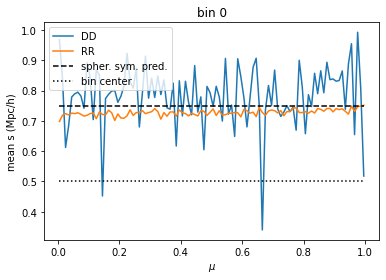

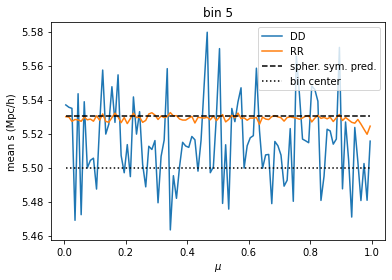

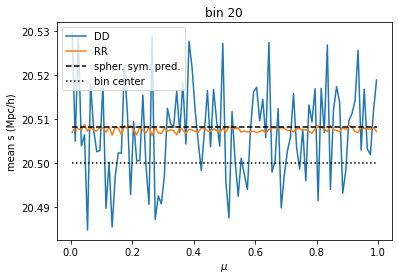

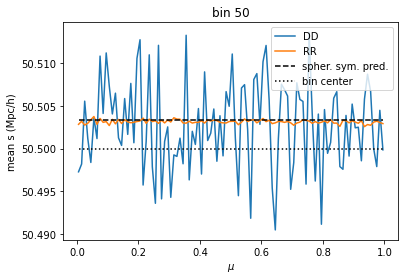

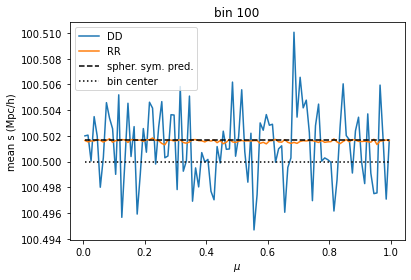

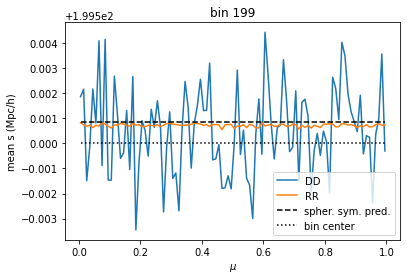

In [52]:
#Plot mean separation vs mu for a few rbins, compare DD and RR
sepr = pc.item()['R1R2']['seps']
bns = [0,5,20,50,100,199]
bs = 1. #the s bin size
for bn in bns:
    r = bn + bs/2.
    pss = .75*((r+bs/2.)**4.-(r-bs/2.)**4.)/((r+bs/2.)**3.-(r-bs/2.)**3.) #spherical symmetry prediction   
    mul = seps[1][bn]
    pssa = np.ones(len(mul))*pss
    pca = np.ones(len(mul))*r #bin center array
    rs = seps[0][bn]
    rr = sepr[0][bn]
    plt.plot(mul,rs,label='DD')
    plt.plot(mul,rr,label='RR')
    plt.plot(mul,pssa,'--k',label='spher. sym. pred.')
    plt.plot(mul,pca,':k',label='bin center')
    plt.xlabel(r'$\mu$')
    plt.ylabel('mean s (Mpc/h)')
    plt.title('bin '+str(bn))
    plt.legend()
    plt.show()

In [53]:
#Pretty cool that we have that info along with the paircounts file! 
#Exactly what we need for any tests of windowing needed for xi analysis

In [54]:
#Ok, now get xi_0 for a few binnings
ddn = pc.item()['D1D2']['wcounts']/pc.item()['D1D2']['wnorm']
drn = pc.item()['D1R2']['wcounts']/pc.item()['D1R2']['wnorm']
rrn = pc.item()['R1R2']['wcounts']/pc.item()['R1R2']['wnorm']

In [85]:
xi = (ddn-2.*drn+rrn)/rrn #for fiducial binning

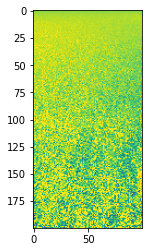

In [76]:
#look at 2D x(s,mu)
plt.imshow(xi*seps[0]**2.,vmax=200)

In [84]:
xi0 = []
rl0 = []
for sb in range(0,len(xi)):
    xi0b = np.sum(xi[sb])/len(seps[1][0])
    rb = np.sum(sepr[0][sb]*rrn[sb])/np.sum(rrn[sb]) #get the separation based on the RR counts
    xi0.append(xi0b)
    rl0.append(rb)
xi0 = np.array(xi0)
rl0 = np.array(rl0)

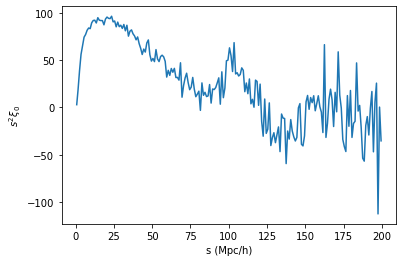

In [83]:
plt.plot(rl0,rl0**2.*xi0)
plt.xlabel('s (Mpc/h)')
plt.ylabel(r'$s^2\xi_0$')
plt.show()

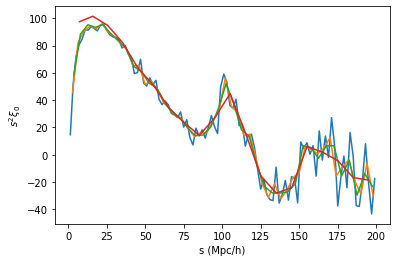

In [95]:
#re-bin
#Note, pycorr already built-in method to do this, might differ somewhat, but for illustration
bsl = [2,4,5,10] #re-binnings; note extra line needed if you want binning like 3 that doesn't align with 200
for bs in bsl:
    xi = np.zeros((len(seps[0])//bs,len(seps[0][1])))
    rs = np.zeros((len(seps[0])//bs,len(seps[0][1])))
    rr = np.zeros((len(seps[0])//bs,len(seps[0][1])))
    for mub in range(0,len(seps[0][1])):
        for sb in range(0,len(seps[0]),bs):
            ddb = 0
            drb = 0
            rrb = 0
            sw = 0
            for ii in range(0,bs):
                ddb += ddn[sb+ii][mub]
                drb += drn[sb+ii][mub]
                rrb += rrn[sb+ii][mub]
                sw += sepr[0][sb+ii][mub]*rrn[sb+ii][mub]
            xib = (ddb-2.*drb+rrb)/rrb
            swb = sw/rrb
            xi[sb//bs][mub] = xib
            rs[sb//bs][mub] = swb
            rr[sb//bs][mub] = rrb
    xi0 = []
    rl0 = []
    for sb in range(0,len(xi)):
        xi0b = np.sum(xi[sb])/len(seps[1][0])
        rb = np.sum(rs[sb]*rr[sb])/np.sum(rr[sb]) #get the separation based on the RR counts
        xi0.append(xi0b)
        rl0.append(rb)
    xi0 = np.array(xi0)
    rl0 = np.array(rl0)        
    plt.plot(rl0,rl0**2.*xi0)
plt.xlabel('s (Mpc/h)')
plt.ylabel(r'$s^2\xi_0$')
plt.show()    
        
              